In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23')

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Convert string to datetime object
most_recent_date = list(np.ravel(most_recent_date))[0]
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

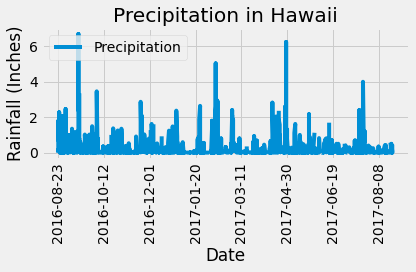

In [15]:
# Convert year, month, and day as seperate integers
most_recent_year = int(dt.datetime.strftime(most_recent_date, '%Y'))
most_recent_month = int(dt.datetime.strftime(most_recent_date, '%m'))
most_recent_day = int(dt.datetime.strftime(most_recent_date, '%d'))


# Calculate the date one year from the last date in data set.
one_year_prior = dt.date(most_recent_year, most_recent_month, most_recent_day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= one_year_prior, Measurement.date <= '2017-08-23').\
                    order_by(Measurement.date).all()
    
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(data=precipitation_data)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by=['date'])
#precipitation_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
plt.plot(precipitation_df['date'], precipitation_df['prcp'])
plt.title("Precipitation in Hawaii")
plt.xlabel('Date')
plt.ylabel('Rainfall (Inches)')
plt.legend(['Precipitation'])
plt.xticks(rotation='vertical')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
fig.tight_layout()
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
station_num = session.query(Station).count()
print(f"Number of Stations: {station_num}")

Number of Stations: 9


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = (session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).\
                        all())
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_id = active_stations[0][0]

# station name
station_name = (session.query(Station.name).\
                filter_by(station = most_active_id))
station_name= station_name[0][0]
print(f"Most active station id and name: {most_active_id}: {station_name}.")

# highest temp
highest_temp = (session.query(Measurement.tobs).\
                      filter(Measurement.station == most_active_id).\
                      order_by(Measurement.tobs.desc()).\
                      first())
highest_temp = highest_temp[0]
print(f"Highest temperature recorded: {highest_temp} degrees Farenheit.")

# lowest temp
lowest_temp = (session.query(Measurement.tobs).\
                     filter(Measurement.station == most_active_id).\
                     order_by(Measurement.tobs.asc()).\
                     first())
lowest_temp = lowest_temp[0]
print(f"Lowest temperature recorded: {lowest_temp} degrees Farenheit.")

# average temp
avg_temp = (session.query(func.avg(Measurement.tobs)).\
            filter(Measurement.station == most_active_id))
avg_temp = '{0:.3}'.format(avg_temp[0][0])
print(f"Average temperature recorded: {avg_temp} degrees Farenheit.")

Most active station id and name: USC00519281: WAIHEE 837.5, HI US.
Highest temperature recorded: 85.0 degrees Farenheit.
Lowest temperature recorded: 54.0 degrees Farenheit.
Average temperature recorded: 71.7 degrees Farenheit.


<AxesSubplot:ylabel='Frequency'>

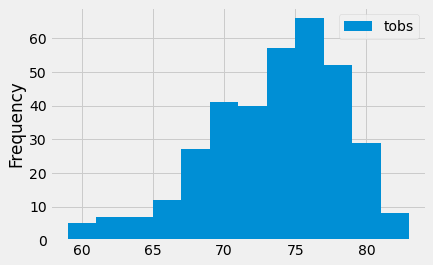

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#query for the last year of temperature data
temp_data = (session.query(Measurement.date, Measurement.tobs).\
             filter(Measurement.date > one_year_prior).\
             filter(Measurement.station == most_active_id).\
             order_by(Measurement.date).\
             all())

#convert query object to data frame
temp_df = pd.DataFrame(temp_data)
temp_df = temp_df.set_index('date')

#sort by date
temp_df = temp_df.sort_index(ascending=True)

#histogram plot with pandas
temp_df.plot(kind='hist', bins=12)

# Close session

In [24]:
# Close Session
session.close()